# TODO


* Check BF's and effect sizes using weaker/stronger priors (probably won't have any effect here, except maybe for max-d in mouse data with CoMs)
* Calculate BF's using ten independent fits (would take 10x time, only do when finalizing the paper submission)

Exploratory analyses
* Run exploratory analysis of trajectory entropy (Calcagni et al 2017, http://polorovereto.unitn.it/~antonio.calcagni/emot.html)
* Run decision landscapes (compare three tertiles of $\Delta$ (SS left, LL right), compare strong discounters to weak discounters, compare walking vs mouse, 1st task vs 2nd task) 

# Contents

* [Preregistered analysis](#prereg)
  * [Mouse-tracking task](#mouse) 
    * [Max-d](#mouse_max_d)
    * [Response time](#mouse_RT)
  * [Walking task](#walking) 
    * [Max-d](#walking_max_d)
    * [Response time](#walking_RT)
* [Effect of changes-of-mind](#com)
  * [Mouse-tracking task](#com_mouse)
  * [Walking task](#com_walking)
* [Exploratory analysis](#explore)

In [1]:
library(tmvtnorm)
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(mefa)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)
library(diptest)

# data_path = "../data/choices_processed.txt"
data_path = "C:/Users/Arkady/Google Drive/data/beyond_the_reach"
figure_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/figures"
table_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/tables"

figure_format = "png"

Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
mefa 3.2-7 	 2016-01-11

Attaching package: 'mefa'

The following object is masked from 'package:reshape2':

    melt

NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following objects are masked from 'package:ggplot2':

    geom_errorbarh, GeomErrorbarh

Loading required package: viridisLite

Attaching package: 'data.

Load processed data

In [2]:
get_processed_data <- function(data_path){
    filename <- file.path(data_path, "choices_processed.txt")
    data <- read.table(filename, header = TRUE, sep = ",")
    data[, "subj_id"] <- as.factor(data[, "subj_id"])
    data[, "option_chosen"] <- as.factor(data[, "option_chosen"])
    
    return(data)
}

In [3]:
data <- get_processed_data(data_path)
mouse_data <- data[data$task=="mouse",]
walking_data <- data[data$task=="walking",]

# Checking for max-d unimodality<a class="anchor" id="com"></a>

Checking for unimodality of the max-d distributions

In [53]:
print(dip.test(mouse_data$max_d, simulate.p.value = TRUE))
print(dip.test(walking_data$max_d, simulate.p.value = TRUE))


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  mouse_data$max_d
D = 0.0052932, p-value = 0.965
alternative hypothesis: non-unimodal, i.e., at least bimodal


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  walking_data$max_d
D = 0.0061884, p-value = 0.8445
alternative hypothesis: non-unimodal, i.e., at least bimodal



Hartigans' dip test doesn't provide evidence in favor of multimodality. Still, the histograms of max-d for the walking task reveal that there are at least two distinct clusters of trajectories. For this reason, we check the robustness of the max-d analysis using a subset of trajectories which exclude changes-of-mind (CoM; see preprocessing notebook for a criterion used to detect CoMs)

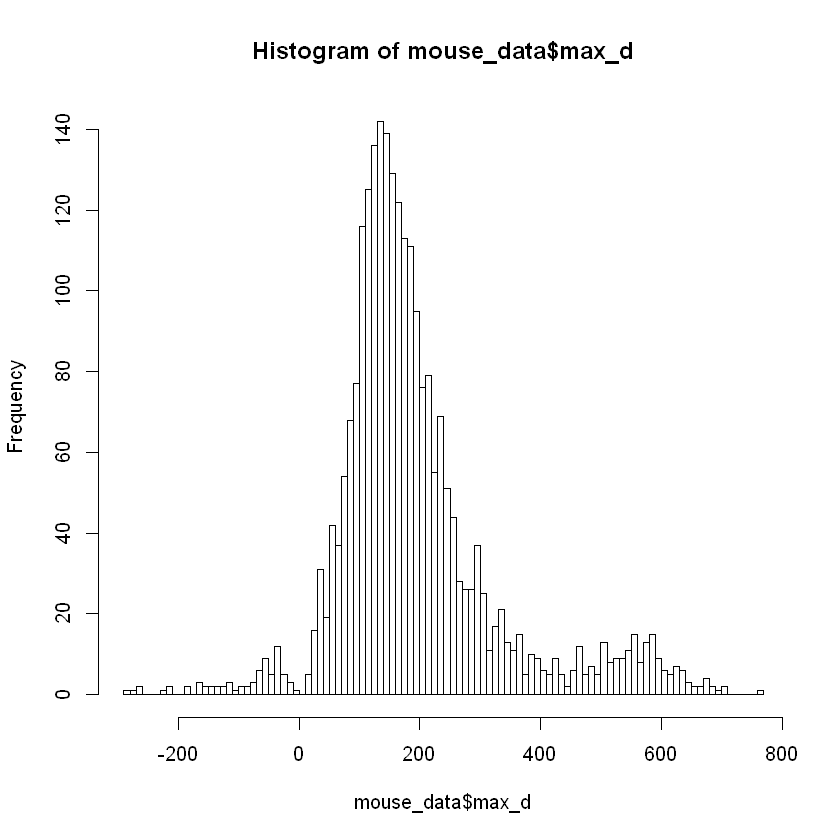

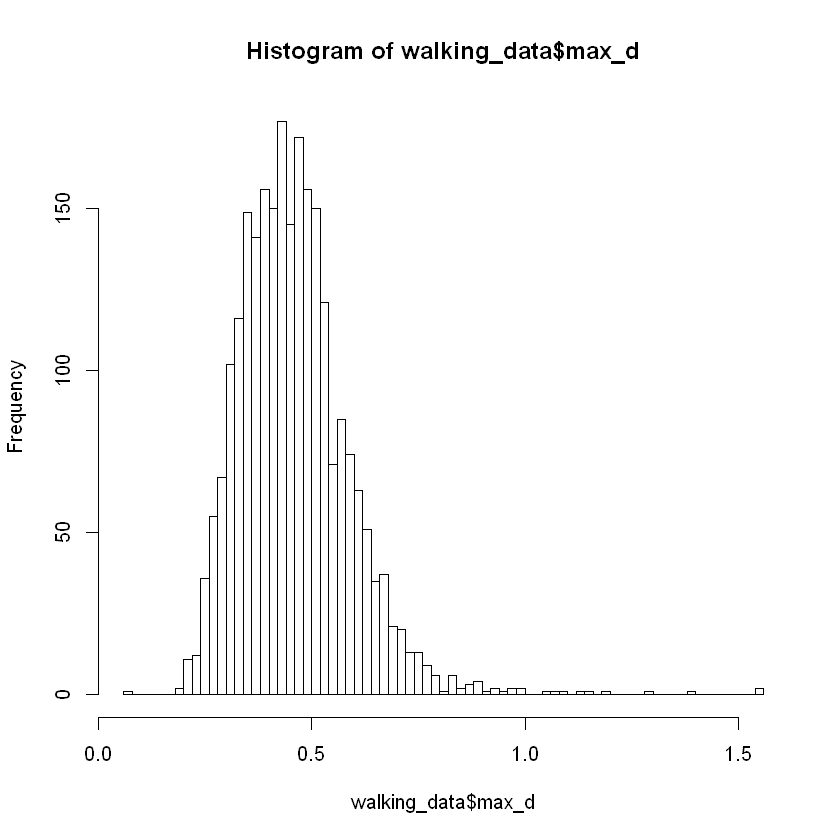

In [54]:
hist(mouse_data$max_d, breaks = 100, freq = TRUE)
hist(walking_data$max_d, breaks = 100, freq = TRUE)

In [55]:
mouse_data_no_com <- mouse_data[mouse_data$is_com=="False",]
walking_data_no_com <- walking_data[walking_data$is_com=="False",]

# Functions for model fitting and BF calculation

In [5]:
get_bf_dyn <- function(models, data, formulas, prior){ 
    " This function fits three models to the supplied data, and returns these models with pairwise BF's"
    m_inter <- fit_model(models$m_inter, data, formulas$f_inter, prior)
    m_choice <- fit_model(models$m_choice, data, formulas$f_choice, prior[1,])
    m_null <- fit_model(models$m_null, data, formulas$f_null, prior[1,])
    
    bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
    ci_inter <- HPDinterval(as.mcmc(m_inter, combine_chains = TRUE))
    
    result = list(bf = bf, models = list(m_null = m_null, m_choice = m_choice, m_inter = m_inter), ci_inter = ci_inter)
    
    return(result)
}

fit_model <- function(model, data, formula, prior){
    " This function updates the brms model if it exists (to avoid slow recompilation of the C++ model by Stan), 
    or creates a model from scratch if it doesn't exist yet "
    if(!is.null(model)){
        model <- update(model, newdata = data, recompile = F)        
    } else {
        model <- brm(formula, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior, refresh = 0)
    }
    return(model)
}

run_analysis <- function(dv, iv, data, rscale){
    " This function runs our analysis for a given dataset (fake or real) and given dependent and 
    independent variables (dv and iv); rscale parameter defines the scale of prior distribution 
    on regression slopes (see Rouder & Morey (2012))"
    models <- list(m_inter = NULL, m_choice = NULL, m_null = NULL)

    " Priors on centered intercepts are the values of DV when all predictors are at their means (see brms docs).
    brms accepts priors on non-standardized b coefficients. We compute them by scaling default priors on standardized 
    coefficients (Rouder & Morey, 2012) to sd(DV)/sd(IV)"
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, dv]), sd(data[, dv])), class = "Intercept"),
               set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, dv])/sd(data[, iv])), class = "b"))

    interaction_term = paste(iv, "option_chosen", sep=':')
    formulas <- list(f_inter = as.formula(paste(dv, "~ (option_chosen | subj_id) + option_chosen +", interaction_term)),
                     f_choice = as.formula(paste(dv, "~ (option_chosen | subj_id) + option_chosen")),
                     f_null = as.formula(paste(dv, "~ (1 | subj_id)")))

    bf_result <- get_bf_dyn(models, data, formulas, prior)
    
    analysis_id <- paste(dv, iv, deparse(substitute(data)))
    
    bf_result$analysis_id <- analysis_id    
    print_bf(bf_result, analysis_id, iv)
    
    return(bf_result)
}

# Functions for visualizing and saving the results

In [6]:
print_bf <- function(bf_result, analysis_name, iv="Delta"){
    print(analysis_name)
    print(sprintf("BF of choice model over null model: %g", bf_result$bf[1]))
    print(sprintf("BF of choice-by-delta model over null model: %g", bf_result$bf[2]))
    print(sprintf("BF of choice-by-delta model over choice-only model: %g", bf_result$bf[3]))
    
    print(bf_result$ci[c(paste("b_", iv, ":option_chosenll", sep=""), 
                         paste("b_", iv, ":option_chosenss", sep="")),])

}

spaghetti_plot <- function(model, data, dv, iv, task, figure_format){
    file_name=sprintf("spaghetti_%s_%s.%s", task, dv, figure_format)
    plt <- plot(marginal_effects(model, spaghetti=TRUE, nsamples=300), plot=FALSE)[[1]]                                                                            
    plt <- plt + 
        geom_point(aes_string(x=iv, y=dv, shape='option_chosen', colour='option_chosen'), 
                   size = 3, alpha=0.1, data = data) +
        theme_pander(base_size = 24) +
        ggtitle(paste(task, gsub("_", "-", dv))) +
#         labs(fill = "choice") +
#         guides(fill=guide_legend(title="choice"))
        theme(plot.title = element_text(hjust = 0.5, size=24, face="plain")) +
        xlab(TeX("$\\Delta$")) +
        ylab(gsub("_", "-", dv)) +
        theme(legend.position="none") +
        scale_color_viridis(discrete=TRUE, alpha=0.2, begin=0.0, end=0.7)
    if ((dv == 'RT') & (task == 'walking')){   
        plt <- plt + theme(legend.position = c(0.9, 0.9), 
                           legend.key.size = unit(24, "points"),
                           legend.title = element_blank(),
                           legend.text = element_text(size=24),
                           legend.key = element_rect(colour = "transparent", fill = "white")) 
#         guides(color=guide_legend(override.aes=list(fill=NA)), fill=guide_legend(title="choice"))
#         plt <- plt + guides(linetype = guide_legend(override.aes = list(size = 10)))
    }
    ggsave(file.path(figure_path, file_name), dpi=150, width=8, height=4) 
}

joyplot <- function(model, file_name){
    m <- as.matrix(as.mcmc(model, combine_chains = FALSE))

    # Only keep the choice-by-lambda interaction parameters    
    m <- m[,grep(",option_chosen", colnames(m))]
    
    # Reformat column names
    colnames(m) <- sub("r_subj_id\\[", "s", colnames(m))
    colnames(m) <- sub(",option_chosenss]", "", colnames(m))
    
    # Reorder columns(parameters) by their mean values and plot the result        
    plt <- mcmc_areas_ridges(m[,order(colMeans(m))])#, prob=0.95)
    
    plt <- plt + theme_pander(base_size = 12) +
        xlab("Offset of regression coefficient for SS choices") #+
#         scale_color_manual(values = c("#D55E00", "#0072B2"), guide = "none")
#     +
#        scale_color_viridis(discrete=TRUE, alpha=0.4, begin=0.0, end=0.7)
    ggsave(file.path(figure_path, file_name), dpi=150, width=4, height=8)
}

posterior_plot <- function(model, iv, file_name){
    plot <- mcmc_areas_ridges(as.matrix(as.mcmc(model, combine_chains = TRUE)), 
                              regex_pars = paste("b_", iv, ":option_chosen", sep=""), prob=0.95)
    ggsave(file.path(figure_path, file_name), dpi=150, width=8, height=4)
}

save_posterior <- function(model, file_name){    
    write.csv(as.matrix(as.mcmc(model, combine_chains=TRUE)), 
              file=file.path("posterior_csv", file_name), row.names=FALSE)
}

visualize_model <- function(model, data, task, dv, iv, figure_format){
    spaghetti_plot(model, data, dv, iv, task, figure_format)
    joyplot(model, file_name=sprintf("joy_%s_%s.%s", task, dv, figure_format))
    save_posterior(model, file_name = sprintf("posterior_%s_%s.%s", task, dv, "csv"))
#     posterior_plot(model, iv, file_name=sprintf("posterior_%s_%s.%s", task, dv, figure_format))
}

# Functions for aggregating the results

In [7]:
save_all_plots <- function(results, iv){
    visualize_model(results$mouse_max_d_bf$models$m_inter, mouse_data, "mouse", "max_d", "Delta", figure_format)
    visualize_model(results$mouse_rt_bf$models$m_inter, mouse_data, "mouse", "RT", iv, figure_format)
    visualize_model(results$walking_max_d_bf$models$m_inter, walking_data, "walking", "max_d", iv, figure_format)
    visualize_model(results$walking_rt_bf$models$m_inter, walking_data, "walking", "RT", iv, figure_format)
    visualize_model(results$mouse_max_d_no_com_bf$models$m_inter, mouse_data_no_com, 
                    "mouse_no_com", "max_d", iv, figure_format) 
    visualize_model(results$walking_max_d_no_com_bf$models$m_inter, walking_data_no_com, 
                    "walking_no_com", "max_d", iv, figure_format)    
    visualize_model(results$walking_rt_no_com_bf$models$m_inter, walking_data_no_com, 
                    "walking_no_com", "RT", iv, figure_format)    
    visualize_model(results$mouse_rt_no_com_bf$models$m_inter, mouse_data_no_com, 
                    "mouse_no_com", "RT", iv, figure_format)
}

print_all_bfs <- function(results, iv){
    print_bf(results$mouse_max_d_bf, "mouse task max-d analysis", iv)
    print_bf(results$mouse_rt_bf, "mouse task RT analysis", iv)
    print_bf(results$walking_max_d_bf, "walking task max-d analysis", iv)
    print_bf(results$walking_rt_bf, "walking task RT analysis", iv)    

    print_bf(results$mouse_max_d_no_com_bf, "mouse task max-d no CoM analysis", iv)
    print_bf(results$mouse_rt_no_com_bf, "mouse task RT no CoM analysis", iv)
    print_bf(results$walking_max_d_no_com_bf, "walking task max-d no CoM analysis", iv)
    print_bf(results$walking_rt_no_com_bf, "walking task RT no CoM analysis", iv)    
}

run_all_analyses <- function(iv, rscale){
    mouse_max_d_bf <- run_analysis("max_d", iv, mouse_data, rscale)
    mouse_rt_bf <- run_analysis("RT", iv, mouse_data, rscale)
    
    walking_max_d_bf <- run_analysis("max_d", iv, walking_data, rscale)
    walking_rt_bf <- run_analysis("RT", iv, walking_data, rscale)
    
    mouse_max_d_no_com_bf <- run_analysis("max_d", iv, mouse_data_no_com, rscale)        
    mouse_rt_no_com_bf <- run_analysis("RT", iv, mouse_data_no_com, rscale)    
    
    walking_max_d_no_com_bf <- run_analysis("max_d", iv, walking_data_no_com, rscale)
    walking_rt_no_com_bf <- run_analysis("RT", iv, walking_data_no_com, rscale)
        
    return(list(mouse_max_d_bf = mouse_max_d_bf, mouse_rt_bf = mouse_rt_bf, 
                walking_max_d_bf = walking_max_d_bf, walking_rt_bf = walking_rt_bf, 
                mouse_max_d_no_com_bf = mouse_max_d_no_com_bf, mouse_rt_no_com_bf = mouse_rt_no_com_bf,
                walking_max_d_no_com_bf = walking_max_d_no_com_bf, walking_rt_no_com_bf = walking_rt_no_com_bf))
}

# Run analyses (takes a lot of time!)

In [ ]:
lambda_results <- run_all_analyses("Lambda", rscale=0.707)

In [ ]:
delta_results <- run_all_analyses("Delta", rscale=0.707)

In [ ]:
delta_results_narrow_priors <- run_all_analyses("Delta", rscale=0.5)

In [ ]:
delta_results_wide_priors <- run_all_analyses("Delta", rscale=1.0)

Compiling the C++ model


# Print Bayes factors

In [108]:
print_all_bfs(lambda_results, 'Lambda')

[1] "mouse task max-d analysis"
[1] "BF of choice model over null model: 2.96549e+74"
[1] "BF of choice-by-delta model over null model: 2.68863e+75"
[1] "BF of choice-by-delta model over choice-only model: 8.98548"
                              lower     upper
b_Lambda:option_chosenll -11.218003 -3.770717
b_Lambda:option_chosenss  -1.933067  4.618961
[1] "mouse task RT analysis"
[1] "BF of choice model over null model: 1.00679e+08"
[1] "BF of choice-by-delta model over null model: 2.82883e+19"
[1] "BF of choice-by-delta model over choice-only model: 2.9449e+11"
                               lower       upper
b_Lambda:option_chosenll -0.15145158 -0.07744219
b_Lambda:option_chosenss  0.06866046  0.13029267
[1] "walking task max-d analysis"
[1] "BF of choice model over null model: 7.74145e+67"
[1] "BF of choice-by-delta model over null model: 2.50419e+76"
[1] "BF of choice-by-delta model over choice-only model: 2.90041e+08"
                                lower        upper
b_Lambda:opti

In [109]:
print_all_bfs(delta_results, 'Delta')

[1] "mouse task max-d analysis"
[1] "BF of choice model over null model: 3.59026e+74"
[1] "BF of choice-by-delta model over null model: 6.58773e+83"
[1] "BF of choice-by-delta model over choice-only model: 1.8783e+09"
                            lower     upper
b_Delta:option_chosenll -100.1092 -42.33949
b_Delta:option_chosenss   35.1366  68.99659
[1] "mouse task RT analysis"
[1] "BF of choice model over null model: 1.05444e+08"
[1] "BF of choice-by-delta model over null model: 1.26663e+47"
[1] "BF of choice-by-delta model over choice-only model: 1.21729e+39"
                             lower      upper
b_Delta:option_chosenll -1.4247551 -0.9233783
b_Delta:option_chosenss  0.7192841  0.9983055
[1] "walking task max-d analysis"
[1] "BF of choice model over null model: 9.14502e+67"
[1] "BF of choice-by-delta model over null model: 9.65165e+82"
[1] "BF of choice-by-delta model over choice-only model: 9.07761e+14"
                              lower       upper
b_Delta:option_chosenll -0.

# Save plots

In [80]:
save_all_plots(delta_results)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


# Generate tables with Bayes factors

In [29]:
save_bf_table <- function(results, caption, label, file_name){
    hyp_1_format_string <- "\\begin{table}[]
                            \\caption{%s}
                            \\label{%s}
                            \\begin{tabular}{@{}llll@{}}
                            \\toprule
                             &  & max-d & RT \\\\ \\midrule
                            \\multirow{2}{*}{walking} & All data & \\num{%g} & \\num{%g} \\\\
                             & CoM excluded &  \\num{%g} & \\num{%g} \\\\
                            \\multirow{2}{*}{mouse-tracking} & All data & \\num{%g} & \\num{%g} \\\\
                             & CoM excluded & \\num{%g} & \\num{%g} \\\\ \\cmidrule(l){1-4} 
                            \\end{tabular}
                            \\end{table}"
    
    output <- sprintf(hyp_1_format_string, caption, label, 
                      results$walking_max_d_bf$bf[3], results$walking_rt_bf$bf[3],
                      results$walking_max_d_no_com_bf$bf[3], results$walking_rt_no_com_bf$bf[3],
                      results$mouse_max_d_bf$bf[3], results$mouse_rt_bf$bf[3],
                      results$mouse_max_d_no_com_bf$bf[3], results$mouse_rt_no_com_bf$bf[3])

    fileConn<-file(file.path(table_path, file_name))
    writeLines(output, fileConn)
    close(fileConn)    
}

In [7]:
caption = "Results of testing Hypothesis 1 using $\\Delta$ instead of $\\lambda$ to measure relative values of the options:
        Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\Delta}$ over $\\textrm{M}_{\\textrm{choice}}$"
label = "tab:hyp_1_bf_delta"
file_name = "hyp_1_bf_delta.tex"

save_bf_table(delta_results, caption, label, file_name)

In [8]:
caption = "Results of testing Hypothesis 1: Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\lambda}$ over $\\textrm{M}_{\\textrm{choice}}$"
label = "tab:hyp_1_bf_lambda"
file_name = "hyp_1_bf_lambda.tex"

save_bf_table(lambda_results, caption, label, file_name)

# Save coefficients 

In [4]:
m <- as.mcmc(delta_results$mouse_max_d_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "max_d_coeffs_walking.csv")

m <- as.mcmc(delta_results$mouse_rt_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "RT_coeffs_mouse.csv")

# Save all results to RData file

In [110]:
save.image()